# Implementing GAN

This is my implementation of a Generative Adversarial Network (GAN), inspired by the original paper *"Generative Adversarial Networks"* by Ian Goodfellow et al., published in 2014. You can find the paper [here](https://arxiv.org/abs/1406.2661).

The basic premise of GAN networks is that you train two separate models, discriminator *D* and generator *G*, and pit them against each other so they can improve together. The discriminator's objective is to correctly predict if the data comes from the true training sample or if it is a fake image. On the other hand, the goal for the generator is to confuse *D* as much as possible, which would require it to model the distribution of the data and get good at creating new data. We train the models in the same training cycle so that they both improve in sync.

A note about this notebook's goals: I am not setting out to break any benchmark records here or to train a flawless model. This notebook is created for educational purposes, and hence I will not be utilizing the newer and more advanced methods in the field of GANs like WGAN or spectral normalization.


### Libraries

First, we will import the libraries we need.


In [15]:
import torch 
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### Loading the Data

We will load the MNIST handwritten digits dataset and normalize the pixel values to be in the range [-1, 1]. This promotes faster convergence and numerical stability.

We are also abstaining from doing test/train split. The goal of our models has nothing to do with predicting or classifying the data, rather it is to recognize what the data looks like and create a generator that makes believable samples.

In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
batch_size = 64
data_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

Now, let's check that our data loader works.

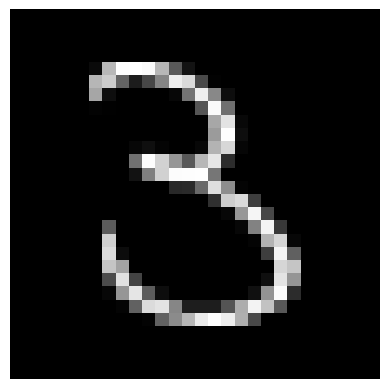

In [22]:
image, label = next(iter(data_loader))
image_np = image.numpy()

plt.imshow(image_np[0,0,:,:], cmap='gray')
plt.axis('off')  
plt.show()

### Create the Models

We need to create the discriminative model, *D*, and the generative model, *G*. In the original paper on this topic, they were designed to be FNNs (or MLPs as they called them), so this shouldn't be too bad to implement.

A few points on model design:
- The common consensus is that the generator model should be more complex and capable than the discriminator model. The discriminator model is only learning a binary classification task, while the generator is trying to model the distribution of the data, so the two tasks are not of the same difficulty and hence should not be of the same size.
- I played around with different regularization techniques and found that using batch normalization did help the generator's output quality and it's training stability. There are a ton of other methods we could use to enhance the model's capacities, but for the purposes of this paper this architecture is good enough.
- *D* outputs probabilities given an input, so we utilize a sigmoid activation in the output layer.
- *G* takes in some noise vector, which are just vectors of random numbers, and transforms it into the fake data. 
    - Since we elected to normalize the pixel values, our output needs to be in the normalized range [-1,1] which is why we utilize the $tanh$ activation funciton in *G*.

In [158]:
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.Sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Flatten the input image
        x = x.view(x.size(0), -1)
        
        x = self.LeakyReLU(self.fc1(x))
        x = self.LeakyReLU(self.fc2(x))
        x = self.Sigmoid(self.fc3(x))
        
        return x
    
class Generator(nn.Module):
    def __init__(self, noise_size, output_size):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(noise_size, 256) 
        self.fc2 = nn.Linear(256, 512)        
        self.fc3 = nn.Linear(512, 1024)       
        self.fc4 = nn.Linear(1024, output_size)  

        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(512)
        self.bn3 = nn.BatchNorm1d(1024)

        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.Tanh = nn.Tanh()
    
    def forward(self, z):
        z = self.LeakyReLU(self.bn1(self.fc1(z)))
        z = self.LeakyReLU(self.bn2(self.fc2(z)))
        z = self.LeakyReLU(self.bn3(self.fc3(z)))
        z = self.Tanh(self.fc4(z))
        
        return z

### Loss Function

In the paper, they talk about how the training is actually a minimax game between two players, which can be expressed as $$ \min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))] $$
Now this looks like a lot, but it actually just says something like: *D* wants to label the true data correctly, while *G* wants to trick *D*.
- $\underset{G}{min} \space \underset{D}{max} V(D, G)$ - *G* wants to minimize $V(D,G)$ while *D* wants to maximize it.
- $\mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)]$ - This is the expectation over input $x$ from the true data. In order to maximize this value, *D* would need to output 1, i.e., it has to be confident in identifying true data when given it.
- $\mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]$ - This is where the competition lies. To maximize this value, *D* would have to never be confused by the generated data from *G*, i.e., $D(G(z)) = 0$. To minimize this value, *G* would have to confuse *D* into thinking that the generated data actually came from the true distribution.

Overall, this is actually just a Binary Cross Entropy function: $y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)$, where the true labels ($y_i$) are whether the data came from our generative model or the MNIST dataset. This is why we will utilize BCE as loss of choice.


### Training Method

The training routine, as described in the paper, is to train the discriminator for $k$ amount of epochs then train the generative model once. This hyperparameter $k$ determines how strong the model *D* is before it has to judge *G*'s output. If you set $k$ too high then the model will get good at telling apart fake data quickly and the gradient for *G* will vanish, setting it too low could make the learning process slower as generator could have to wait until *D* becomes competent.

We will use two different losses for the discrimantor: one for real data and one for fake data. While we can mix in fake data into the batches and train on those, implementing it with two seperate losses for fake and real data is just simpler.

Lastly, there is some label smoothing used for the stability of the training process.


In [ ]:
def train_GAN(generator, discriminator, data_loader, k=1, num_epochs=10, noise_size=100, lr=0.0001, device='cpu'):

    d_losses = []
    g_losses = []

    bce_loss = nn.BCELoss().to(device)
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr / 2) # Lowering G's learning rate is a common practice to stabilize training

    generator.to(device)
    discriminator.to(device)

    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(data_loader):
            real_images = real_images.view(real_images.size(0), -1).to(device)  # convert (batch_size, 1, 28, 28) to (batch_size, 784)
            batch_size = real_images.size(0)
            
            generator.eval()

            # Train the discriminator
            for _ in range(k):
                discriminator.train()
                optimizer_D.zero_grad()

                # Train on real images
                real_labels = (torch.ones(batch_size, 1) - 0.1 * torch.rand(batch_size, 1)).to(device)  # Adding some noise to the labels
                outputs = discriminator(real_images)
                d_loss_real = bce_loss(outputs, real_labels)

                # Train on fake images
                noise = torch.randn(batch_size, noise_size).to(device)
                with torch.no_grad():
                    fake_images = generator(noise)
                fake_labels = (torch.zeros(batch_size, 1) + 0.1 * torch.rand(batch_size, 1)).to(device)  # Adding some noise to the labels
                outputs = discriminator(fake_images)
                d_loss_fake = bce_loss(outputs, fake_labels)

                # Sum the losses and backpropagate
                d_loss = (d_loss_real + d_loss_fake) / 2
                d_losses.append(d_loss.item())
                d_loss.backward()
                optimizer_D.step()

            # Train the generator 
            generator.train()
            discriminator.eval()
            # Create fake images
            noise = torch.randn(batch_size, noise_size).to(device)
            fake_images = generator(noise)
            
            optimizer_G.zero_grad()
            outputs = discriminator(fake_images)
            g_loss_value = bce_loss(outputs, real_labels)
            g_losses.append(g_loss_value.item())
            g_loss_value.backward()
            optimizer_G.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss_value.item():.4f}')

    return d_losses, g_losses

### Training Curves

Below is the training curve for the models that we trained. This can teach us a few things about training GANs and what we should expect:

- The generator loss usually rises initially due to the learned capabilities of the discriminator.
- Then the generator loss goes down as the generator improves, and consequently, the discriminator loss rises (not the most obvious on this graph).
- Over time, the two models settle into a rhythm where they are in a sort of "skill equilibrium," and their losses flatline as neither model can gain an advantage over the other.
- From my experiments: noise size is not that important of a parameter, and I saw little difference when trying different values.

Training GANs is a notoriously difficult thing to do and requires a lot of fine-tuning. Playing around with these hyperparameters has been the most educational part of this project, and I would encourage anyone reading this to do so too.

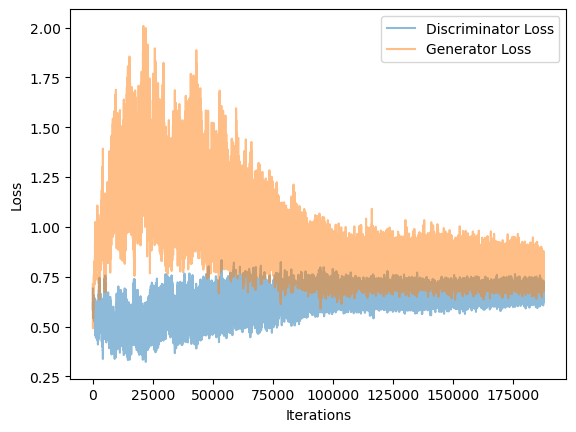

In [157]:
input_size = 784 # 1*28*28
noise_size = 100

d = Discriminator(input_size)
g = Generator(noise_size=noise_size, output_size=input_size)

d_losses, g_losses = train_GAN(g, d, data_loader, k=1, num_epochs=200, noise_size=noise_size, lr=0.00005)

plt.plot(d_losses, label='Discriminator Loss', alpha=0.5)
plt.plot(g_losses, label='Generator Loss', alpha=0.5)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Saving/Uploading

In case you want to run this code yourself, here are the functions to save and upload the model.

In [ ]:
def save_model(generator, discriminator, d_losses, g_losses, path='gan_model.pth'):
    torch.save({
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'd_losses': d_losses,
        'g_losses': g_losses
    }, path)

def load_model(generator, discriminator, path='gan_model.pth'):
    checkpoint = torch.load(path)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    d_losses = checkpoint['d_losses']
    g_losses = checkpoint['g_losses']
    
    return d_losses, g_losses

# Uncomment the following lines to save and load the model
#save_model(g, d, d_losses=d_losses, g_losses=g_losses, path='gan_model.pth')
#d_losses, g_losses = load_model(g, d, path='gan_model.pth')

### Results

We can now generate some random noise and see how our model did. Although not consistent, the generator has learned to create real looking hand-written numbers. The example I picked might be a little cherry-picked, but simply as a proof-of-concept this model performed well. When I was experimenting with model design I noticed that it tended to experience a lot of *mode collapse* where it only tried to represent one number well, so I am happy to see a diverse set of numbers in our outputs. 

Quantitatively objectifying the model's performance is much more difficult for GAN's than other types of models. We do not have a metric that tells us how accurate the model is at predicting a label or how far off it is when predicting a value. What the generator learns is a distribution of the data. It is possible to compare two distributions with different metrics like KL-divergence, but we don't have either of the distributions we only have samples. The common metric for image generation with GANs is the Frechet Inception Distance (FID) which uses a pretrained network to compare feature vectors. This falls out of the scope of this notebook and hence we will not utilize it here.

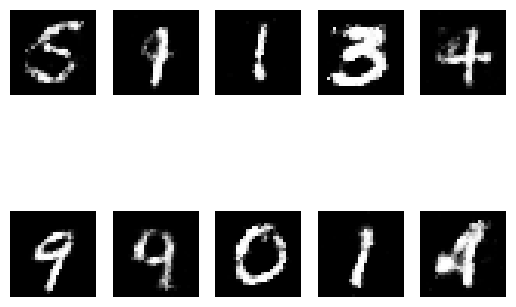

In [297]:
num_samples = 10
g.eval() 
noise = torch.randn(num_samples, noise_size)
fake_images = g(noise)

# Unnormalize the pixel values from [-1, 1] back to [0, 255]
fake_images_np = ((fake_images.view(num_samples, 28, 28).detach().numpy() + 1) * 127.5).astype('uint8')

for i in range(num_samples):
    plt.subplot(2, num_samples // 2, i+1)
    plt.imshow(fake_images_np[i], cmap='gray')
    plt.axis('off')
plt.show()